In [1]:
# import pandas as pd
# prices = pd.read_csv('data/prices_hist.csv')

In [2]:
# # Данные по ценам арматуры
# prices.head()

# Importing packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from darts.timeseries import TimeSeries
from darts.models import (
    LinearRegressionModel,
    ARIMA,
    RandomForest,
    Theta,
    RegressionEnsembleModel,
    NBEATSModel
)
from darts.metrics import mape, mse

import warnings
warnings.filterwarnings('ignore')

# Reproducibility

In [4]:
import torch
torch.manual_seed(0)

import random
random.seed(0)
import numpy as np
np.random.seed(0)

In [5]:
prices = pd.read_csv('data\prices_hist.csv')

In [6]:
prices.head()

,datetime,price
0,2018-01-05,36550.0
1,2018-01-12,36850.0
2,2018-01-19,36850.0
3,2018-01-26,35200.0
4,2018-02-02,34650.0


In [7]:
prices.shape

(261, 2)

In [8]:
series = TimeSeries.from_dataframe(prices, time_col="datetime")

In [9]:
%matplotlib inline

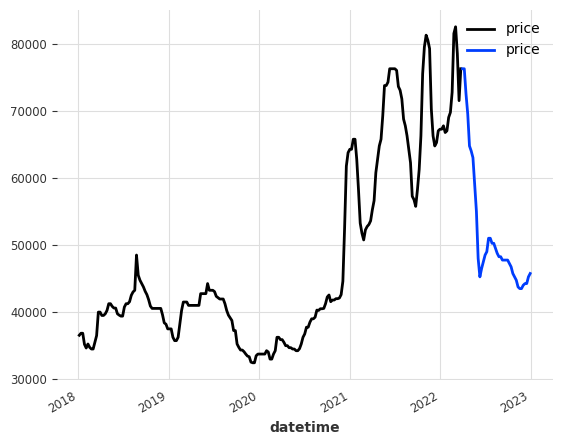

In [111]:
# деление на тренировачные и валидационные серии данных после 75%
train, val = series.split_before(0.85)
train.plot()
val.plot()

In [112]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [113]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

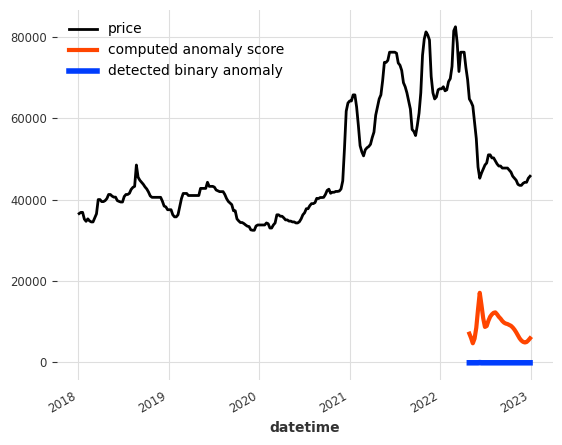

In [114]:
import matplotlib.pyplot as plt

series.plot()
(anom_score / 2. - 100).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom * 45 - 150).plot(label="detected binary anomaly", lw=4)

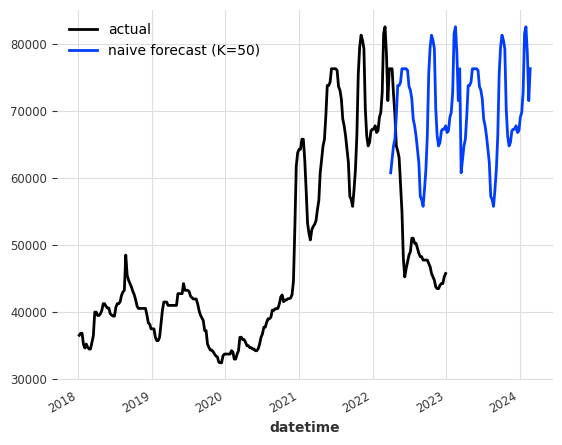

In [122]:
from darts.models import NaiveSeasonal
n = 50
naive_model = NaiveSeasonal(K=n)
naive_model.fit(train)
naive_forecast = naive_model.predict(100)

series.plot(label="actual")
naive_forecast.plot(label=f"naive forecast (K={n})")

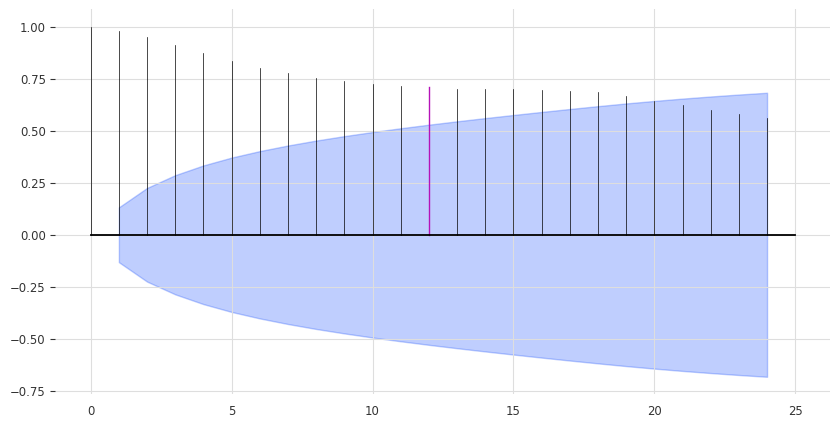

In [131]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

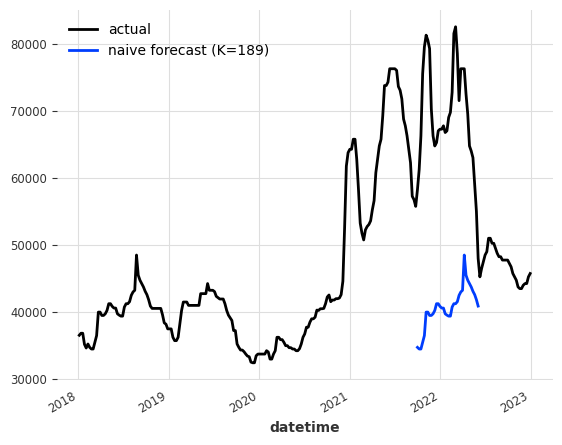

In [107]:
t = 189
seasonal_model = NaiveSeasonal(K=t)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label=f"naive forecast (K={t})")

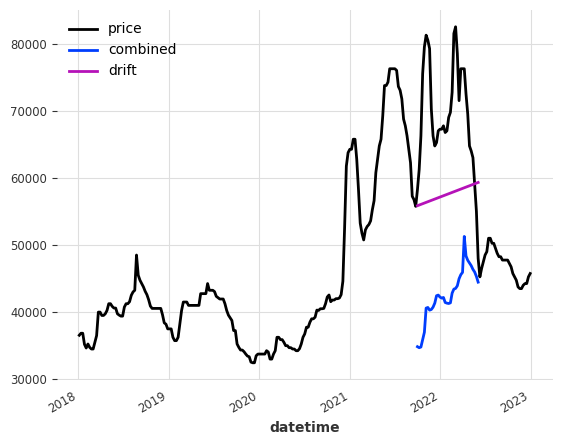

In [108]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [132]:
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 37.90%.
